# Trading Strategies powered by Machine Learning - Regression

## Linear Regression with scikit-learn - a Simple Introduction

In [26]:
import sys
sys.path.append('../../')

In [27]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [29]:
import warnings
warnings.simplefilter("ignore")

In [30]:
from backtesting import Strategy

## Getting the Data

In [31]:
XAUUSD = load_data()

In [32]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [33]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


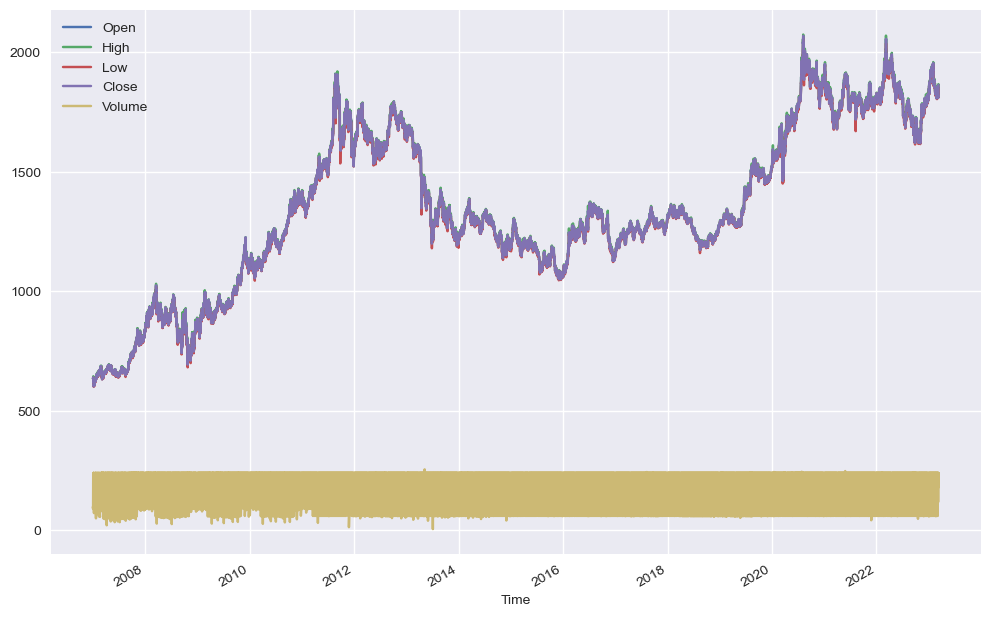

In [34]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [35]:
class Linear_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred == 1:
            if not self.position :
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)
            
        elif self.data.pred == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

        

In [36]:
strategy = Linear_Regression
account_size = 1000
folder_ML_Strategy = 'Linear Regression'

In [37]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_Regression():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF, account_size):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None
        self.account_size = account_size

    def Prepare(self, lags=1):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        # data["returns_signal"] = data["returns"].shift(-1)
        data.dropna(inplace=True)
        cols = []

        for lag in range(1, lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        lm = LinearRegression(fit_intercept=True)
        lm.fit(data[cols], data['returns'])
        data["pred"] = lm.predict(data[cols])
        data['pred'] = np.sign(data['pred'])


        self.model = lm
        self.data_train = data

    def Predict(self, lags=1):
        data = self.data.loc[self.start_test:self.end_test].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        
        cols = []

        for lag in range(1, lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        data["pred"] = self.model.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.data_test = data

    def Backtest(self, data):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=self.account_size , margin= 1/100)
        result = backtest.run()
        return result

    def Save_Result(self, df, file_path):

        equity_curve = df['_equity_curve'].copy()
        equity_df = pd.DataFrame(equity_curve, columns=['Equity'])
        equity_df['returns'] = equity_df['Equity'].pct_change().fillna(0)
        equity_df = equity_df.drop('Equity', axis=1)
        equity_df.to_csv(file_path, index=True)

    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)
        self.Predict()
        result_test = self.Backtest(self.data_test)
       

        return result_train, result_test

## TF D1

In [38]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'D1'


In [39]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [40]:
train , test = ml.Run()

### In-Sample Backtesting

In [41]:
train

Start                     2007-01-03 00:00:00
End                       2020-12-31 00:00:00
Duration                   5111 days 00:00:00
Exposure Time [%]                   99.954149
Equity Final [$]                      2272.81
Equity Peak [$]                       2446.91
Return [%]                            127.281
Buy & Hold Return [%]              202.866094
Return (Ann.) [%]                    4.857439
Volatility (Ann.) [%]               12.743528
Sharpe Ratio                         0.381169
Sortino Ratio                        0.558812
Calmar Ratio                         0.129725
Max. Drawdown [%]                  -37.444256
Avg. Drawdown [%]                   -2.221185
Max. Drawdown Duration     3261 days 00:00:00
Avg. Drawdown Duration       65 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                     204.543701
Worst Trade [%]                    204.543701
Avg. Trade [%]                    

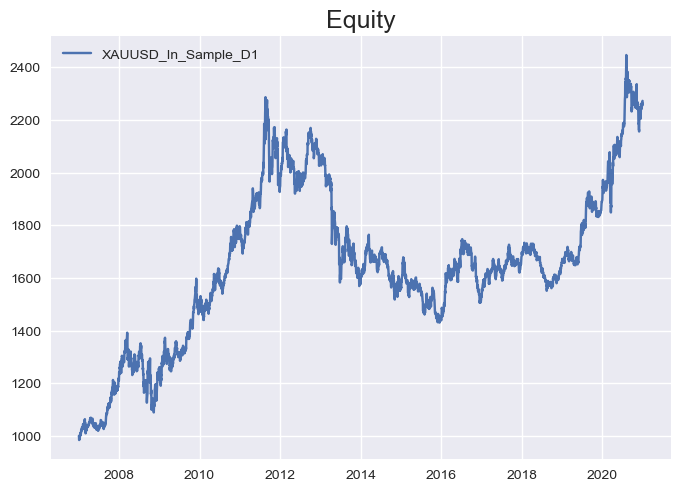

In [42]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [43]:
test

Start                     2020-01-03 00:00:00
End                       2023-03-10 00:00:00
Duration                   1162 days 00:00:00
Exposure Time [%]                   99.797776
Equity Final [$]                     1262.283
Equity Peak [$]                      1500.033
Return [%]                            26.2283
Buy & Hold Return [%]               20.146953
Return (Ann.) [%]                    6.114571
Volatility (Ann.) [%]               23.395261
Sharpe Ratio                         0.261359
Sortino Ratio                        0.388658
Calmar Ratio                         0.207348
Max. Drawdown [%]                  -29.489351
Avg. Drawdown [%]                    -5.15348
Max. Drawdown Duration      946 days 00:00:00
Avg. Drawdown Duration       71 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                      16.715026
Worst Trade [%]                     16.715026
Avg. Trade [%]                    

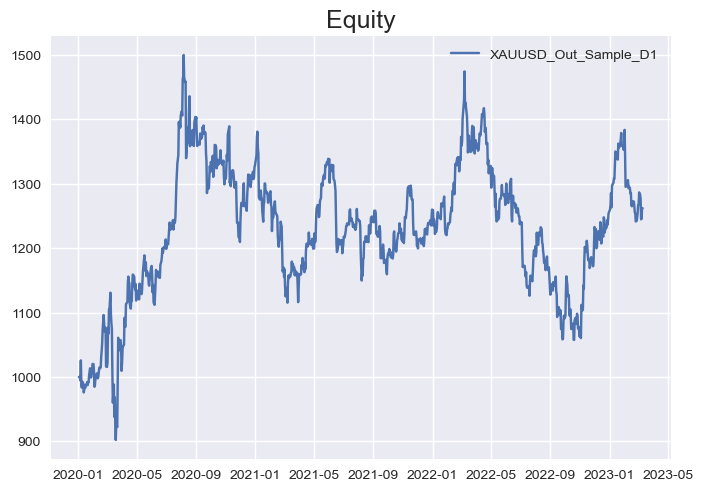

In [44]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [45]:
filename_train = f'result_{TF}_In_Sample.csv'

In [46]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [47]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [48]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [49]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H4'


In [50]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [51]:
train , test = ml.Run()

### In-Sample Backtesting

In [52]:
train

Start                     2007-01-01 08:00:00
End                       2020-12-31 20:00:00
Duration                   5113 days 12:00:00
Exposure Time [%]                     99.9911
Equity Final [$]                      2327.44
Equity Peak [$]                      2526.206
Return [%]                            132.744
Buy & Hold Return [%]              198.394007
Return (Ann.) [%]                    4.998825
Volatility (Ann.) [%]               12.319385
Sharpe Ratio                         0.405769
Sortino Ratio                        0.599273
Calmar Ratio                         0.112492
Max. Drawdown [%]                  -44.437344
Avg. Drawdown [%]                   -1.112955
Max. Drawdown Duration     3272 days 12:00:00
Avg. Drawdown Duration       22 days 01:00:00
# Trades                                 1011
Win Rate [%]                        56.478734
Best Trade [%]                      11.494498
Worst Trade [%]                    -12.579104
Avg. Trade [%]                    

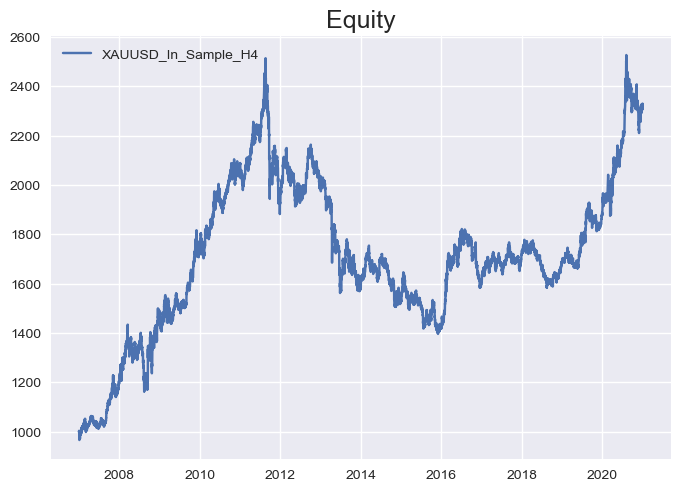

In [53]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [54]:
test

Start                     2020-01-02 04:00:00
End                       2023-03-10 16:00:00
Duration                   1163 days 12:00:00
Exposure Time [%]                   99.960807
Equity Final [$]                     1396.837
Equity Peak [$]                      1640.749
Return [%]                            39.6837
Buy & Hold Return [%]               22.708422
Return (Ann.) [%]                    8.692598
Volatility (Ann.) [%]               21.917385
Sharpe Ratio                         0.396607
Sortino Ratio                        0.600188
Calmar Ratio                         0.278043
Max. Drawdown [%]                  -31.263466
Avg. Drawdown [%]                   -1.847944
Max. Drawdown Duration      945 days 20:00:00
Avg. Drawdown Duration       25 days 02:00:00
# Trades                                  181
Win Rate [%]                        58.563536
Best Trade [%]                       5.116969
Worst Trade [%]                     -7.854748
Avg. Trade [%]                    

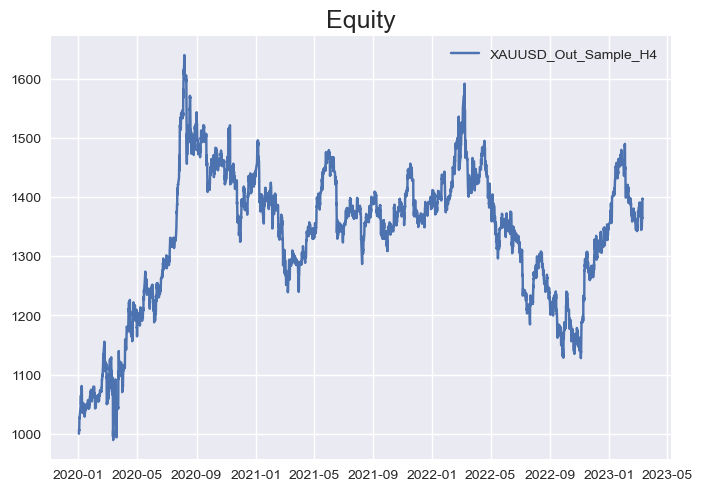

In [55]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [56]:
filename_train = f'result_{TF}_In_Sample.csv'

In [57]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [58]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [59]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [60]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H1'


In [61]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [62]:
train , test = ml.Run()

### In-Sample Backtesting

In [63]:
train

Start                     2007-01-01 02:00:00
End                       2020-12-31 21:00:00
Duration                   5113 days 19:00:00
Exposure Time [%]                   99.997647
Equity Final [$]                     2089.026
Equity Peak [$]                      2261.293
Return [%]                           108.9026
Buy & Hold Return [%]              198.348973
Return (Ann.) [%]                    4.342202
Volatility (Ann.) [%]               13.582597
Sharpe Ratio                         0.319689
Sortino Ratio                        0.465395
Calmar Ratio                         0.084598
Max. Drawdown [%]                  -51.327581
Avg. Drawdown [%]                    -0.89613
Max. Drawdown Duration     3335 days 22:00:00
Avg. Drawdown Duration       14 days 13:00:00
# Trades                                 3475
Win Rate [%]                        54.935252
Best Trade [%]                       7.008369
Worst Trade [%]                    -11.105848
Avg. Trade [%]                    

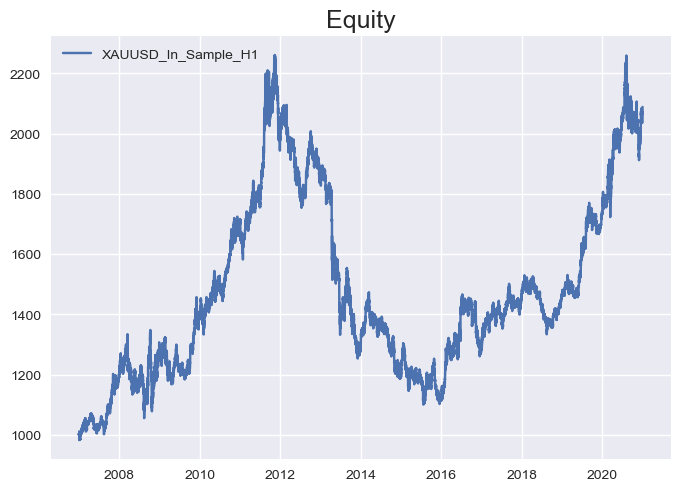

In [64]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [65]:
test

Start                     2020-01-02 01:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 16:00:00
Exposure Time [%]                   99.989396
Equity Final [$]                     1139.204
Equity Peak [$]                      1520.059
Return [%]                            13.9204
Buy & Hold Return [%]               22.689281
Return (Ann.) [%]                    3.159166
Volatility (Ann.) [%]               22.628197
Sharpe Ratio                         0.139612
Sortino Ratio                          0.2015
Calmar Ratio                         0.081643
Max. Drawdown [%]                  -38.694814
Avg. Drawdown [%]                   -1.525456
Max. Drawdown Duration      945 days 19:00:00
Avg. Drawdown Duration       13 days 15:00:00
# Trades                                  633
Win Rate [%]                        52.290679
Best Trade [%]                       3.992523
Worst Trade [%]                     -6.187112
Avg. Trade [%]                    

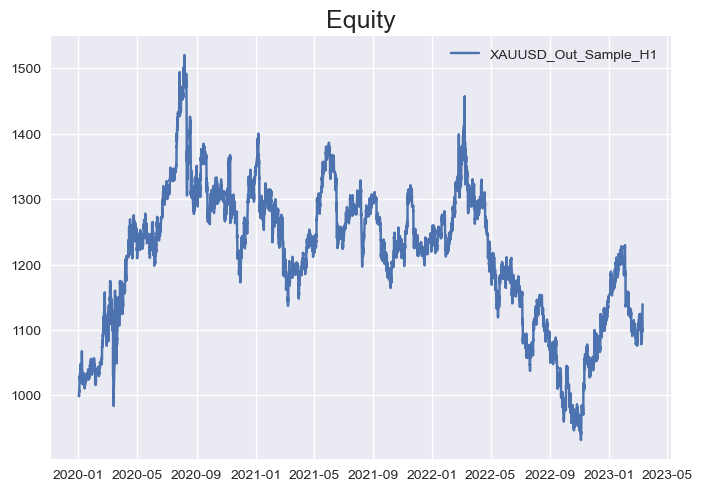

In [66]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [67]:
filename_train = f'result_{TF}_In_Sample.csv'

In [68]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [69]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [70]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [71]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M30'


In [72]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [73]:
train , test = ml.Run()

### In-Sample Backtesting

In [74]:
train

Start                     2007-01-01 01:00:00
End                       2020-12-31 21:30:00
Duration                   5113 days 20:30:00
Exposure Time [%]                   99.998819
Equity Final [$]                     3102.644
Equity Peak [$]                       3394.07
Return [%]                           210.2644
Buy & Hold Return [%]              198.465809
Return (Ann.) [%]                    6.766266
Volatility (Ann.) [%]               13.361219
Sharpe Ratio                         0.506411
Sortino Ratio                        0.773863
Calmar Ratio                         0.222417
Max. Drawdown [%]                  -30.421579
Avg. Drawdown [%]                   -0.512179
Max. Drawdown Duration     2523 days 11:30:00
Avg. Drawdown Duration        6 days 11:10:00
# Trades                                49820
Win Rate [%]                        54.132878
Best Trade [%]                       4.383939
Worst Trade [%]                     -5.755643
Avg. Trade [%]                    

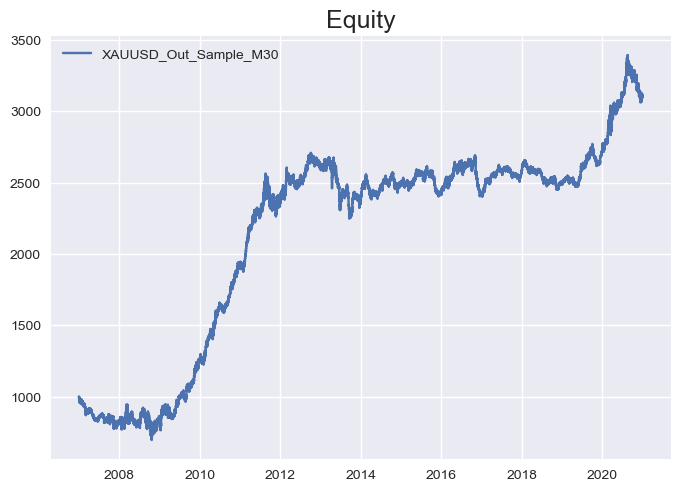

In [75]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [76]:
test

Start                     2020-01-02 00:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 17:30:00
Exposure Time [%]                   99.994697
Equity Final [$]                     1692.277
Equity Peak [$]                      1702.225
Return [%]                            69.2277
Buy & Hold Return [%]               22.702203
Return (Ann.) [%]                   13.858594
Volatility (Ann.) [%]               21.183844
Sharpe Ratio                         0.654206
Sortino Ratio                        1.072408
Calmar Ratio                         0.518023
Max. Drawdown [%]                  -26.752847
Avg. Drawdown [%]                   -1.093511
Max. Drawdown Duration      564 days 09:30:00
Avg. Drawdown Duration        6 days 17:54:00
# Trades                                11589
Win Rate [%]                        54.439555
Best Trade [%]                       1.915367
Worst Trade [%]                     -4.848957
Avg. Trade [%]                    

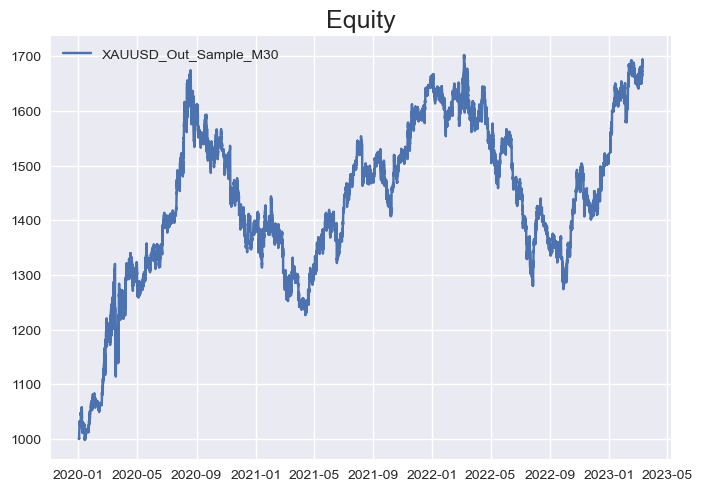

In [77]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [78]:
filename_train = f'result_{TF}_In_Sample.csv'

In [79]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [80]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [81]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [82]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M15'


In [83]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [84]:
train , test = ml.Run()

### In-Sample Backtesting

In [85]:
train

Start                     2014-09-23 13:30:00
End                       2020-12-31 21:45:00
Duration                   2291 days 08:15:00
Exposure Time [%]                   99.998651
Equity Final [$]                     1560.879
Equity Peak [$]                      2060.244
Return [%]                            56.0879
Buy & Hold Return [%]               54.859418
Return (Ann.) [%]                     5.87467
Volatility (Ann.) [%]               12.326592
Sharpe Ratio                         0.476585
Sortino Ratio                        0.729183
Calmar Ratio                         0.212987
Max. Drawdown [%]                  -27.582315
Avg. Drawdown [%]                   -0.550335
Max. Drawdown Duration     1343 days 09:00:00
Avg. Drawdown Duration        4 days 12:57:00
# Trades                                73215
Win Rate [%]                        52.399099
Best Trade [%]                       2.433492
Worst Trade [%]                     -2.940285
Avg. Trade [%]                    

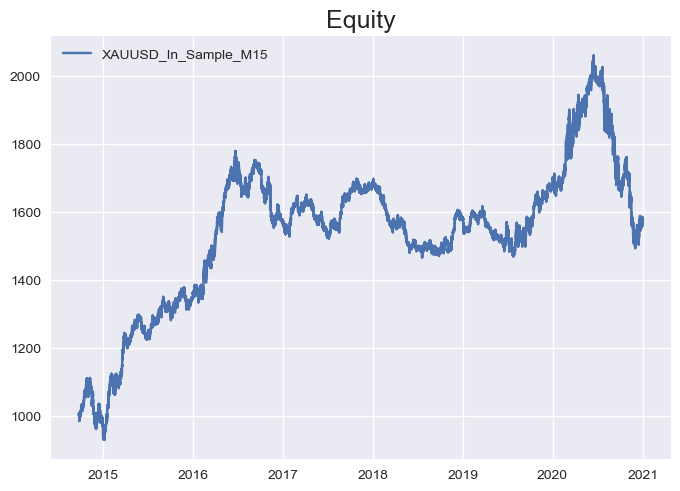

In [86]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [87]:
test

Start                     2020-01-01 23:30:00
End                       2023-03-10 17:45:00
Duration                   1163 days 18:15:00
Exposure Time [%]                   99.997348
Equity Final [$]                     1246.897
Equity Peak [$]                      1365.995
Return [%]                            24.6897
Buy & Hold Return [%]               22.692269
Return (Ann.) [%]                     5.77149
Volatility (Ann.) [%]               26.905207
Sharpe Ratio                         0.214512
Sortino Ratio                        0.313622
Calmar Ratio                         0.138736
Max. Drawdown [%]                  -41.600665
Avg. Drawdown [%]                   -1.143214
Max. Drawdown Duration      997 days 05:45:00
Avg. Drawdown Duration        9 days 08:36:00
# Trades                                37502
Win Rate [%]                        52.253213
Best Trade [%]                       2.056397
Worst Trade [%]                     -2.894386
Avg. Trade [%]                    

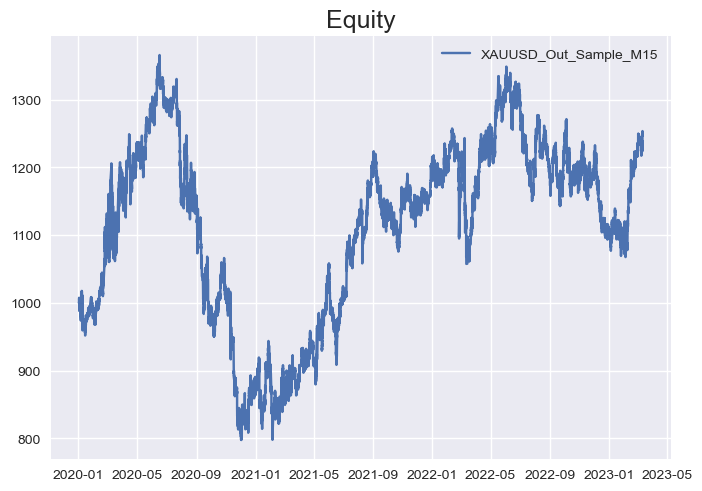

In [88]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [89]:
filename_train = f'result_{TF}_In_Sample.csv'

In [90]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [91]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [92]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [93]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M5'


In [94]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [95]:
train , test = ml.Run()

### In-Sample Backtesting

In [96]:
train

Start                     2020-05-15 11:20:00
End                       2023-03-10 17:55:00
Duration                   1029 days 06:35:00
Exposure Time [%]                      99.999
Equity Final [$]                     1855.075
Equity Peak [$]                      1946.361
Return [%]                            85.5075
Buy & Hold Return [%]                7.465707
Return (Ann.) [%]                   20.357541
Volatility (Ann.) [%]               20.070884
Sharpe Ratio                         1.014282
Sortino Ratio                         1.77113
Calmar Ratio                         1.162789
Max. Drawdown [%]                  -17.507515
Avg. Drawdown [%]                   -0.402889
Max. Drawdown Duration      345 days 04:20:00
Avg. Drawdown Duration        1 days 10:39:00
# Trades                               103142
Win Rate [%]                        52.109713
Best Trade [%]                       1.008559
Worst Trade [%]                     -3.754972
Avg. Trade [%]                    

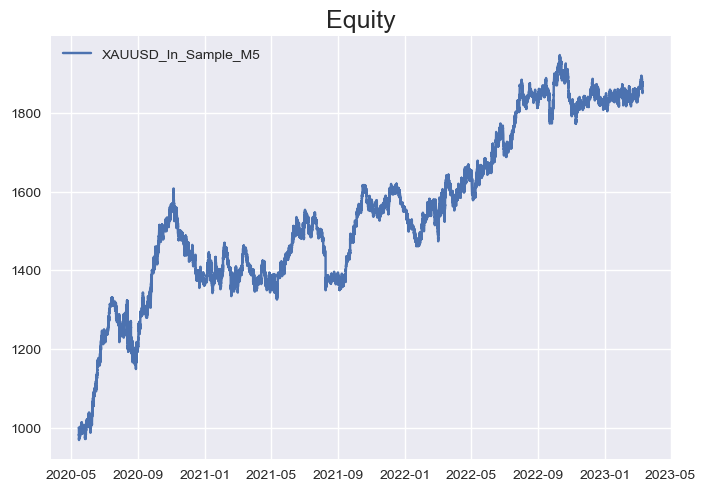

In [97]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [98]:
test

Start                     2023-01-02 23:10:00
End                       2023-03-10 17:55:00
Duration                     66 days 18:45:00
Exposure Time [%]                   99.985068
Equity Final [$]                     1012.548
Equity Peak [$]                      1051.502
Return [%]                             1.2548
Buy & Hold Return [%]                2.074288
Return (Ann.) [%]                    4.458025
Volatility (Ann.) [%]               17.908074
Sharpe Ratio                         0.248939
Sortino Ratio                        0.359418
Calmar Ratio                         0.818499
Max. Drawdown [%]                   -5.446586
Avg. Drawdown [%]                   -0.595133
Max. Drawdown Duration       33 days 01:55:00
Avg. Drawdown Duration        1 days 04:34:00
# Trades                                 6913
Win Rate [%]                        52.292782
Best Trade [%]                       0.412583
Worst Trade [%]                     -1.464118
Avg. Trade [%]                    

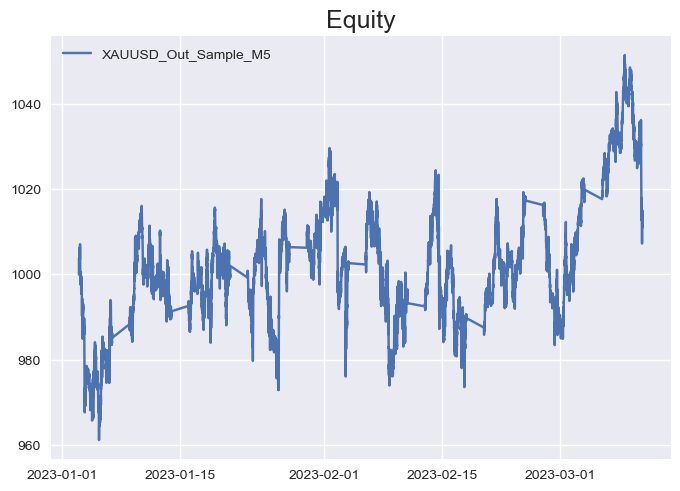

In [99]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [100]:
filename_train = f'result_{TF}_In_Sample.csv'

In [101]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [102]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [103]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [104]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M1'


In [105]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [106]:
train , test = ml.Run()

### In-Sample Backtesting

In [107]:
train

Start                     2022-08-16 23:15:00
End                       2023-03-10 17:59:00
Duration                    205 days 18:44:00
Exposure Time [%]                      99.999
Equity Final [$]                     1620.104
Equity Peak [$]                       1638.81
Return [%]                            62.0104
Buy & Hold Return [%]                4.981871
Return (Ann.) [%]                    99.26084
Volatility (Ann.) [%]               41.379041
Sharpe Ratio                         2.398819
Sortino Ratio                        8.234087
Calmar Ratio                         9.452349
Max. Drawdown [%]                  -10.501182
Avg. Drawdown [%]                   -0.172959
Max. Drawdown Duration       46 days 10:01:00
Avg. Drawdown Duration        0 days 05:19:00
# Trades                                99263
Win Rate [%]                        52.148333
Best Trade [%]                       0.988492
Worst Trade [%]                      -0.80553
Avg. Trade [%]                    

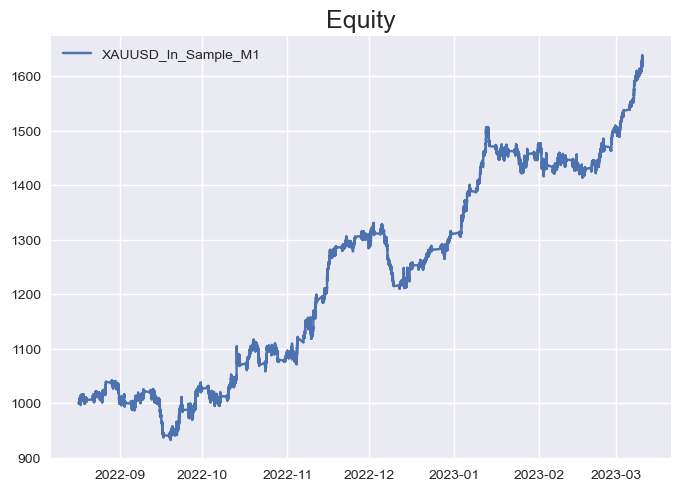

In [108]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [109]:
test

Start                     2023-01-02 23:02:00
End                       2023-03-10 17:59:00
Duration                     66 days 18:57:00
Exposure Time [%]                   99.997013
Equity Final [$]                     1306.258
Equity Peak [$]                      1324.964
Return [%]                            30.6258
Buy & Hold Return [%]                2.045231
Return (Ann.) [%]                  218.842857
Volatility (Ann.) [%]               72.381307
Sharpe Ratio                         3.023472
Sortino Ratio                       18.828345
Calmar Ratio                        27.992617
Max. Drawdown [%]                   -7.817878
Avg. Drawdown [%]                   -0.147931
Max. Drawdown Duration       46 days 10:01:00
Avg. Drawdown Duration        0 days 03:22:00
# Trades                                33296
Win Rate [%]                        52.763095
Best Trade [%]                       0.673684
Worst Trade [%]                     -0.644081
Avg. Trade [%]                    

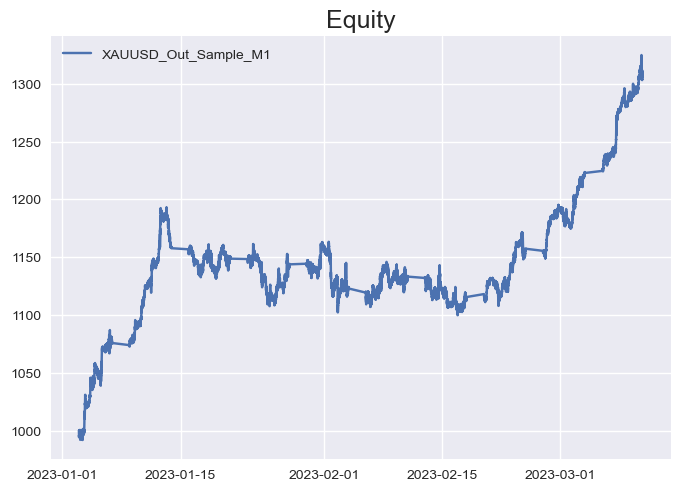

In [110]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [111]:
filename_train = f'result_{TF}_In_Sample.csv'

In [112]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')